In [4]:
# ====== CONFIG (EDIT THESE) ======
DATA_PATH      = "/Users/ahirmansi1301gmail.com/Documents/in-data-we-trust/src/clean_data/clean_data_sample_100000.parquet"  # <-- set your .parquet path
TEXT_COL       = "title_excerpt"                       # <-- set your text column name
N_TOPICS       = 10                           # try 5/10/15 depending on your data size
N_TOP_WORDS    = 15                           # top words to show per topic
MAX_FEATURES   = 10000                        # vocab cap (bag-of-words)

# ====== IMPORTS ======
import os
import pickle
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.lda_model as lda_vis

print("Config OK.")

Config OK.


In [5]:
df = pd.read_parquet('/Users/ahirmansi1301gmail.com/Documents/in-data-we-trust/src/clean_data/clean_data_sample_100000.parquet')
assert TEXT_COL in df.columns, f"Column '{TEXT_COL}' not found. Available: {list(df.columns)}"

display(df[[TEXT_COL]].head(5))
print(f"Rows: {len(df):,}")

,title_excerpt
index,
9005990,days of wine and roses filming discussed day...
16647003,in venezuela women are confronted with a cult...
3916823,this town offers a catholic variety of night c...
3843604,zetland holds brit obligations to india preven...
14639267,less than two days before the n b a draft th...


Rows: 100,000


In [6]:
vectorizer = CountVectorizer(
    stop_words="english",
    max_features=MAX_FEATURES
)

texts = df[TEXT_COL].astype(str).tolist()
count_matrix = vectorizer.fit_transform(texts)   # sparse [n_docs x vocab]
feature_names = np.array(vectorizer.get_feature_names_out())

print("count_matrix shape:", count_matrix.shape)
print("Example vocab terms:", feature_names[:20])

count_matrix shape: (100000, 10000)
Example vocab terms: ['00' '000' '01' '02' '03' '04' '05' '050' '06' '07' '08' '09' '10' '100'
 '100th' '101' '102' '103' '104' '105']


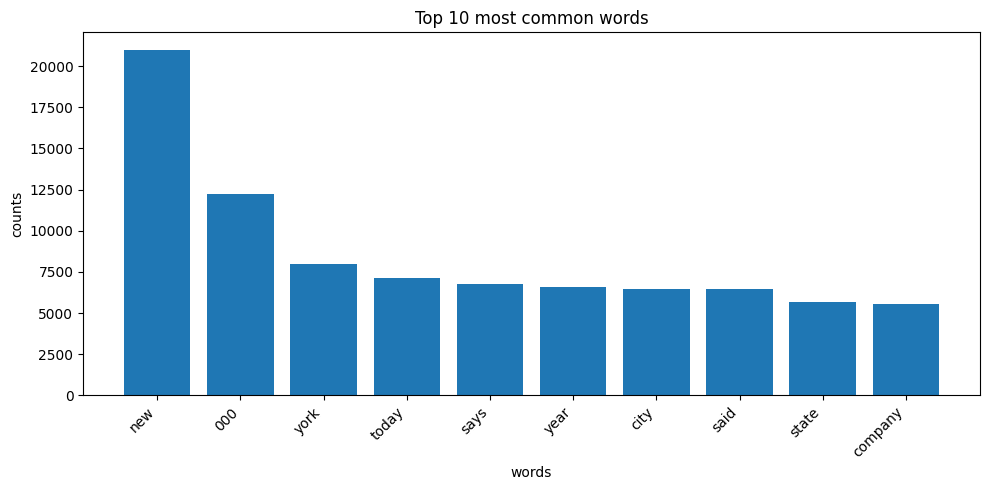

In [7]:
def plot_top_n_words(count_matrix, feature_names, n=10):
    total_counts = np.asarray(count_matrix.sum(axis=0)).ravel()
    top_idx = np.argsort(total_counts)[::-1][:n]
    words = feature_names[top_idx]
    counts = total_counts[top_idx]

    plt.figure(figsize=(10,5))
    plt.bar(range(len(words)), counts)
    plt.xticks(range(len(words)), words, rotation=45, ha='right')
    plt.title("Top 10 most common words")
    plt.xlabel("words")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.show()

plot_top_n_words(count_matrix, feature_names, n=10)

In [8]:
lda = LatentDirichletAllocation(
    n_components=N_TOPICS,
    learning_method="batch",  # stable for offline corpora
    max_iter=20,
    random_state=42,
    n_jobs=-1
)

lda.fit(count_matrix)
print("LDA trained.")

LDA trained.


In [9]:
def get_topic_words(lda, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic_weights in enumerate(lda.components_):
        top_indices = topic_weights.argsort()[::-1][:n_top_words]
        top_terms = feature_names[top_indices]
        top_weights = topic_weights[top_indices]
        topics.append((topic_idx, list(zip(top_terms, top_weights))))
    return topics

topics = get_topic_words(lda, feature_names, N_TOP_WORDS)

print("\n=== Top keywords per topic ===")
for t_idx, term_pairs in topics:
    human_readable = ", ".join([f"{w} ({int(wt)})" for w, wt in term_pairs])
    print(f"Topic {t_idx:02d}: {human_readable}")

# Save for your report
topic_rows = []
for t_idx, term_pairs in topics:
    for rank, (w, wt) in enumerate(term_pairs, start=1):
        topic_rows.append({"topic": t_idx, "rank": rank, "word": w, "weight": wt})
pd.DataFrame(topic_rows).to_csv("topics_keywords.csv", index=False)

print("\nSaved: topics_keywords.csv")


=== Top keywords per topic ===
Topic 00: says (3639), court (2210), state (1973), case (1653), president (1642), house (1618), said (1558), federal (1452), charges (1435), law (1299), pres (1191), campaign (1151), senate (1146), election (1142), sen (1135)
Topic 01: new (4707), york (1859), art (1675), old (1552), years (1543), like (1452), music (1445), year (1442), street (1431), time (1391), life (1259), film (1215), day (1096), american (1075), people (1075)
Topic 02: war (2183), says (1914), united (1726), soviet (1590), world (1516), states (1318), foreign (1287), today (1202), china (1181), talks (1109), president (1103), american (1067), french (1044), british (1036), france (1023)
Topic 03: company (3813), new (2893), said (1989), reports (1935), business (1471), york (1210), million (1199), companies (919), news (918), executive (899), article (869), times (809), earnings (772), chief (764), corporation (744)
Topic 04: new (5049), city (3799), state (2533), plan (2096), plan

In [10]:
doc_topic_dist = lda.transform(count_matrix)  # rows sum to ~1
dominant_topic = doc_topic_dist.argmax(axis=1)
confidence = doc_topic_dist.max(axis=1)

df_out = df.copy()
df_out["dominant_topic"] = dominant_topic
df_out["dominant_topic_confidence"] = confidence

df_out.to_csv("documents_with_topics.csv", index=False)
display(df_out.head(5))
print("Saved: documents_with_topics.csv")

,title_excerpt,dominant_topic,dominant_topic_confidence
index,,,
9005990,days of wine and roses filming discussed day...,1,0.909986
16647003,in venezuela women are confronted with a cult...,1,0.746663
3916823,this town offers a catholic variety of night c...,1,0.880132
3843604,zetland holds brit obligations to india preven...,2,0.791691
14639267,less than two days before the n b a draft th...,6,0.436462


Saved: documents_with_topics.csv


In [12]:
pyLDAvis.enable_notebook()  # enables inline display
ldavis_prepared = lda_vis.prepare(lda, count_matrix, vectorizer)
ldavis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.077170 -0.041691       1        1  15.731868
0     -0.105513 -0.169655       2        1  13.971926
6      0.199471  0.059228       3        1  10.249776
2     -0.163620 -0.176457       4        1  10.181006
7      0.314556 -0.043696       5        1  10.157428
4     -0.059810 -0.067901       6        1   9.321421
9     -0.077400  0.293108       7        1   8.851051
5     -0.004197 -0.102365       8        1   7.677374
3     -0.066386  0.105948       9        1   7.447428
8     -0.114270  0.143480      10        1   6.410722, topic_info=         Term          Freq         Total Category  logprob  loglift
1         000  12315.000000  12315.000000  Default  30.0000  30.0000
2183  company   5587.000000   5587.000000  Default  29.0000  29.0000
6032      mrs   4380.000000   4380.000000  Default  28.0000  28.0000
7610  reports   4405.000000   4405.000000  Default  27.0000  27.0000
1975     city   6480.000000   6480.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
9960     year    530.798735   6601.770690  Topic10  -5.5531   0.2265
4464     high    474.259166   2376.283880  Topic10  -5.6657   1.1357
9199    today    484.235578   7128.611400  Topic10  -5.6449   0.0579
9913    world    469.138312   3886.135265  Topic10  -5.6766   0.6329
7977    sales    462.972341   2123.793187  Topic10  -5.6898   1.2239

[729 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1         3  0.027850    000
1         6  0.050667    000
1         7  0.903066    000
1         8  0.018269    000
5         7  0.991815     04
...     ...       ...    ...
9976      4  0.012583  young
9976      5  0.115603  young
9976      8  0.049544  young
9976      9  0.004718  young
9976     10  0.006291  young

[1813 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 7, 3, 8, 5, 10, 6, 4, 9])

In [13]:
html_path = f"ldavis_prepared_{N_TOPICS}.html"
pyLDAvis.save_html(ldavis_prepared, html_path)
print("Saved:", html_path)

Saved: ldavis_prepared_10.html
